In [1]:
import pandas as pd
from sklearn import linear_model
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn import linear_model,ensemble,metrics,preprocessing
import numpy as np
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

/Users/richardknoche/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1035: UserWarning: Duplicate key in file "/Users/richardknoche/.matplotlib/matplotlibrc", line #2
  (fname, cnt))


In [2]:
df = pd.read_csv('/Users/richardknoche/Desktop/AllImages.csv')
df.drop('Unnamed: 0',axis=1,inplace=True)
df = df.dropna()

#Randomize the data
df = df.sample(frac=1,random_state=102)

In [3]:
#How to get images that are unedited front page images
temp = df[ (df['frac_white']<0.001 ) & (df['is_main']==1)].reset_index()
len(temp)

179

In [ ]:
df.columns

In [4]:
col_to_predict = 'is_main'

num_minority = min(len(df[df[col_to_predict]==False]),len(df[df[col_to_predict]==True]))
true_df = df[df[col_to_predict]==True]
false_df = df[df[col_to_predict]==False]

train_true = true_df.sample(n=np.floor(num_minority*0.6),random_state = 102)
train_false = false_df.sample(n=np.floor(num_minority*0.6),random_state = 102)

train = pd.concat([train_true,train_false])
test = df.drop(train.index)

/Users/richardknoche/anaconda/lib/python3.5/site-packages/pandas/core/generic.py:2644: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  locs = rs.choice(axis_length, size=n, replace=replace, p=weights)


In [5]:
#Not using categoricals for now
features = ['Horizontal_Saturation_Sym', 'Thirds_To_Focal_Distance',
       'Vertical_Value_Sym', 'Salient_Saturation',
       'S_var', 'Thirds_Value', 'V_var', 'FFT_Sharpness', 'R_Mean', 'g_ygrad',
       'Thirds_Vertical_Value_Sym', 'Thirds_Sat', 'b_xgrad_std', 'g_xgrad_std',
       'Thirds_Horizontal_Saliency_Sym', 'Thirds_Saliency', 'G_Mean',
       'Salient_Hue', 'Histogram_Darkness', 'r_ygrad_std', 'Colorfulness',
       'Vertical_Saturation_Sym', 'G_Width', 'H_mean',
       'Thirds_Vertical_Saliency_Sym', 'Thirds_Vertical_Saturation_Sym',
       'r_xgrad_std', 'Lapacian_Saturation', 'Horizontal_Hue_Sym', 'b_ygrad',
       'B_Width', 'g_ygrad_std', 'r_ygrad', 'percieved_luminace',
       'Salient_Value', 'V_mean', 'Thirds_Horizontal_Saturation_Sym',
       'Number_of_Contours', 'Lapacian_Value', 'Complimentary_Color_Level',
       'Vertical_Hue_Sym', 'R_xgrad', 'H_var', 'Horizontal_Value_Sym',
       'Thirds_Horizontal_Value_Sym', 'b_ygrad_std', 'Thirds_Hue', 'g_xgrad',
       'S_mean', 'Laplacian_Sharpness', 'Busyness', 'Thirds_Vertical_Hue_Sym',
       'Lapacian_Hue', 'B_Mean', 'b_xgrad', 'standard_luminance',
       'Thirds_Horizontal_Hue_Sym', 'R_Width']

train_x = train[features]
train_y = train[col_to_predict]

test_x = test[features]
test_y = test[col_to_predict]

#cv_x = cv[features]
#cv_y = cv['view_rate']

# Train Classifier

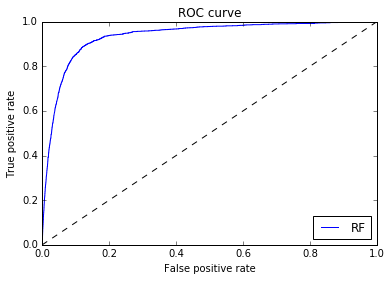

Accuracy:  0.868820517468
0.602771420595


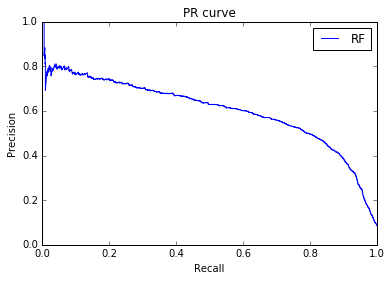

,F-Score,Precision,Recall,Support
0,0.923459,0.989126,0.865969,20167
1,0.541568,0.387492,0.899054,1902


In [6]:
from sklearn import tree
from sklearn.naive_bayes import GaussianNB

#Normalize features
train_std_scale = preprocessing.StandardScaler().fit(train_x)
train_x_std = train_std_scale.transform(train_x)

train_minmax_scale = preprocessing.MinMaxScaler().fit(train_x)
train_x_minmax = train_minmax_scale.transform(train_x)

test_std_scale = preprocessing.StandardScaler().fit(test_x)
test_x_std = test_std_scale.transform(test_x)

test_minmax_scale = preprocessing.MinMaxScaler().fit(test_x)
test_x_minmax = test_minmax_scale.transform(test_x)

train_x_features = train_x
test_x_features = test_x

#Train Model
clf = ensemble.AdaBoostClassifier() #Great and gaussian results
#clf = ensemble.GradientBoostingClassifier() #Awful results
#clf  = ensemble.RandomForestClassifier() #Non-gaussian star rankings
#clf = linear_model.LogisticRegression(penalty='l1') #non-gaussian star rankings
#clf = tree.DecisionTreeClassifier() #non-gaussian results
clf.fit(train_x_features,train_y)
predicted_y = clf.predict(test_x_features)
y_probs =clf.predict_proba(test_x_features)[:, 1]

#ROC
fpr, tpr, thresholds = metrics.roc_curve(test_y, y_probs)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


#Accuracy, Precision, Recall
print('Accuracy: ',clf.score(test_x_features,test_y))
f1score, tpr, thresholds = metrics.roc_curve(test_y, y_probs)

precision, recall, thresholds = precision_recall_curve(test_y,y_probs)
average_precision = average_precision_score(test_y, y_probs)
print(average_precision)


#Prec-Recall Curve
plt.figure()
plt.plot([0, 1], [1, 1], 'k--')
plt.plot(recall, precision,label='RF')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve')
plt.legend(loc='best')
plt.show()


precision, recall, fscore, support = metrics.precision_recall_fscore_support(test_y, predicted_y)
classifier_metrics = pd.DataFrame( {'Precision' : precision, 'Recall' : recall, 'F-Score' : fscore, 'Support' : support})
classifier_metrics

In [7]:
#For RF
importances = clf.feature_importances_

#std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]



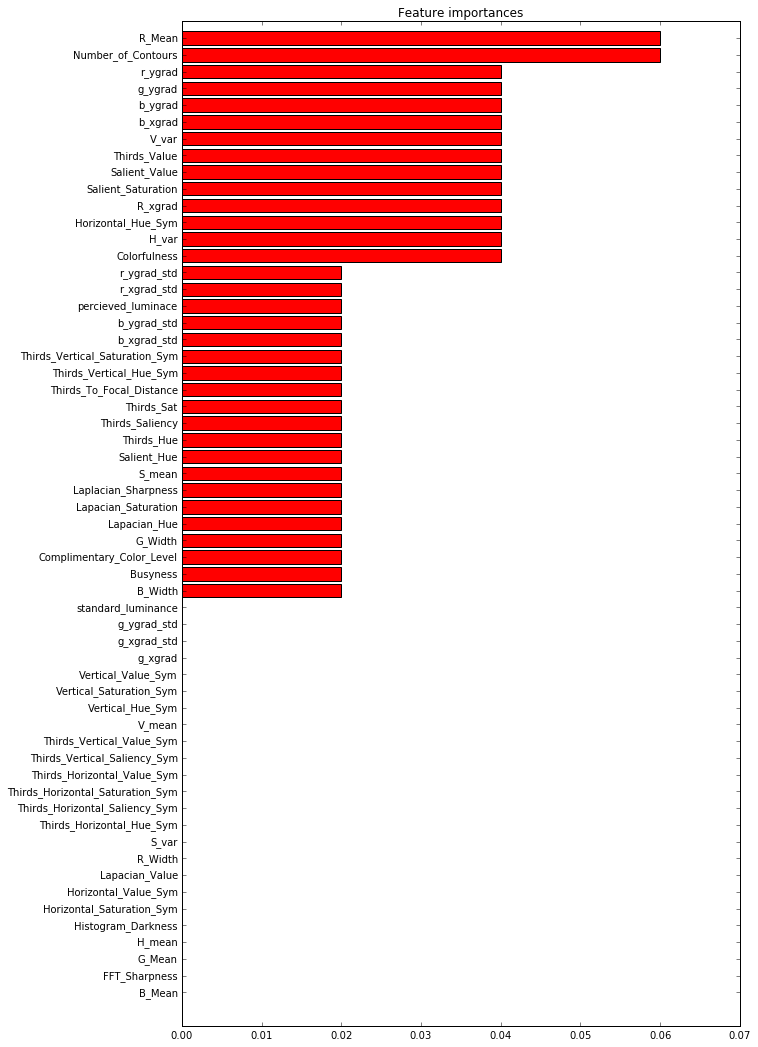

In [8]:
sorted_importances = [importance for (importance,feature) in sorted(zip(importances,features),reverse=True)]
sorted_features = [feature for (importance,feature) in sorted(zip(importances,features),reverse=True)]   
    
plt.figure(figsize=(10,18))
plt.title("Feature importances")
plt.barh(range(len(sorted_features),0,-1), sorted_importances,
       color="r", align="center")
plt.yticks(range(len(sorted_features),0,-1))
ax=plt.gca()
ax.set_yticklabels(sorted_features)
plt.ylim([-1, len(sorted_features)+1])
plt.show()

# Test to see if it can pick out the "best" image

In [10]:
def CalcProb(row):
    row['IsMain_Prob'] = clf.predict_proba(df.ix[0,features])



In [11]:
df['PredictedClass']=clf.predict(df[features])
df['IsMain_Prob']=clf.predict_proba(df[features])[:,1]

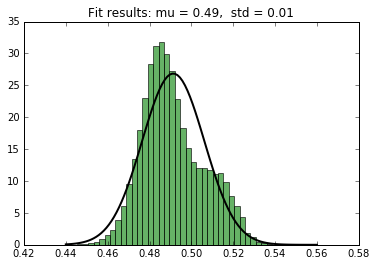

In [13]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Fit a normal distribution to the data:
mu, std = norm.fit(df['IsMain_Prob'])

# Plot the histogram.
plt.hist(df['IsMain_Prob'], bins=40, normed=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

In [14]:
def StarRanking(row):
    stars = (row['IsMain_Prob']-mu)/std+2
    if stars <0:
        stars = 0
    if stars >5:
        stars = 5
    return stars
                 
df['StarRanking']=df.apply(StarRanking,axis=1)

In [15]:
#Compare within listings
sorted_df = df.sort_values('product_id')[['IsMain_Prob','product_id','is_main','StarRanking','path']].reset_index()

for idx in range(0,40):
    print(sorted_df.ix[idx,'product_id'],sorted_df.ix[idx,'is_main'],sorted_df.ix[idx,'IsMain_Prob'],sorted_df.ix[idx,'path'])
    print('     ')

600683 1 0.510118387744 https://d6qwfb5pdou4u.cloudfront.net/product-images/600001-610000/600683/14814294326ad52c966614cf0352f9f4b51ee7b282/200-200-crop-0.jpg
     
600683 0 0.487808653032 https://d6qwfb5pdou4u.cloudfront.net/product-images/600001-610000/600683/1481395417fe8a93f0cc7cb2ea5932b892bea4aa98/200-200-crop-0.jpg
     
600683 0 0.488792177163 https://d6qwfb5pdou4u.cloudfront.net/product-images/600001-610000/600683/14813954074c22d4370e8e4a23cfa42d20a36646a6/200-200-crop-0.jpg
     
600683 0 0.484130260226 https://d6qwfb5pdou4u.cloudfront.net/product-images/600001-610000/600683/1481395432dcb1ef6118467e7478c9de66300ad07f/200-200-crop-0.jpg
     
600683 0 0.491320770791 https://d6qwfb5pdou4u.cloudfront.net/product-images/600001-610000/600683/14813953826938a95a69cad668909cba284d5fecde/200-200-crop-0.jpg
     
600683 0 0.492099736183 https://d6qwfb5pdou4u.cloudfront.net/product-images/600001-610000/600683/1481395446f5d74324551bd8bdb895e187cdbe431e/200-200-crop-0.jpg
     
600683 0 0

In [ ]:
#Check bad images
df.sort_values('IsMain_Prob').ix[:15,'path'].tolist()

In [ ]:
#Check good images
df.sort_values('IsMain_Prob',ascending=False).ix[:15,'path'].tolist()

In [ ]:
df.sort_values('IsMain_Prob',ascending=False).ix[:15,'IsMain_Prob'].tolist()